In [133]:
import numpy as np
import lmfit as lm
import scipy as sp
from matplotlib import pyplot as plt


In [134]:
import os
import re

def get_deg(filename):
    """Извлекаем угол из имени файла"""
    degstring = re.search(r"(?<=-2x)\d+(\-)?\d*(?=deg)", filename)[0].replace('-', '.')
    return float(degstring)
               
working_dir = os.getcwd() + "/data/"
filenames = list(filter(lambda f: ".txt" in f, os.listdir(working_dir))) # Работаем только с .txt
filenames.sort(key=get_deg)
# print(*filenames, sep='\n')

In [135]:
def cut_range(data, startx, endx):
    """Ограничиваем диапазон"""
    xdata = data[:,0]
    if startx <= endx:
        condition = (startx <= xdata) & (xdata <= endx)
    else:
        condition = (startx > xdata) & (xdata > endx)
    return data[condition]

def make_zeros(data, cutout):
    """Заменяем кусочек диапазона нулями"""
    newdata = data
    xdata = data[:,0]
    condition = (cutout[0] <= xdata) & (cutout[1] >= xdata)
    newdata[condition, 1] = min(data[:,1])
    return newdata

In [136]:
def find_closest(point, data):
    """Найти точку в массиве, ближайшую к заданной"""
    xdata = list(data[:,0])
    return sorted(xdata, key=lambda x: abs(x-point))[0]


In [137]:
def fit_peaks(data):
    p = 87
    wcenter = 2
    acenter = max(data[:,1]) * wcenter * np.pi/2
    wshift = 15
    stokes_a = data[np.where(data[:,0] == find_closest(-p, data))[0][0], 1] * wshift * np.pi/2
    antistokes_a = data[np.where(data[:,0] == find_closest(p, data))[0][0], 1] * wshift * np.pi/2
    print(stokes_a)

    stokes = lm.models.PseudoVoigtModel(prefix='stokes_')
    antistokes = lm.models.PseudoVoigtModel(prefix='antistokes_')
    center = lm.models.PseudoVoigtModel(prefix='center_')
    base = lm.models.LinearModel(prefix='base_')
    
    combined = stokes + antistokes + base + center
    combined_params = combined.make_params(
        stokes_center=dict(value=-p, min=-p-1, max=-p+1),
        stokes_amplitude=dict(value=stokes_a, min=stokes_a*0.9, max=stokes_a*1.1),
        stokes_sigma=dict(value=wshift/2, min=(wshift-7)/2, max=(wshift+7)/2),

        antistokes_center=dict(value=p, min=p-1, max=p+1),
        antistokes_amplitude=dict(value=antistokes_a, min=antistokes_a*0.9, max=antistokes_a*1.1),
        antistokes_sigma=dict(value=wshift/2, min=(wshift-7)/2, max=(wshift+7)/2),

        center_center=0, center_amplitude=acenter, center_sigma=wcenter/2,
        base_slope = 0, base_intercept=min(data[:,1])
    )

    return combined.fit(data[:,1], combined_params, x=data[:,0])

#349-00 (GeTe init)-p1-z(xy)z-P 4mWx5%_10x10 s_532nm(T)_ULF_600 (500nm)_x100_Hole 150-2x20deg.txt
33.499666403207705


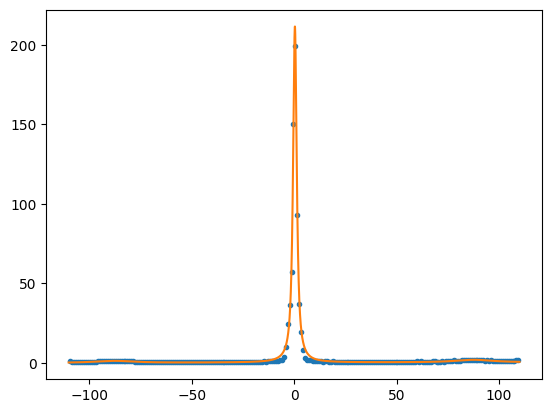

In [138]:
START = -110
END = 110
CUTOUT = [-40, 40]
# plt.yscale('log')
count = 0
for filename in filenames:
    count += 1
    if count != 5:
        continue
    print(filename)
    data = cut_range(np.loadtxt(working_dir + filename), START, END)
    # data = make_zeros(data, CUTOUT)


    fit = fit_peaks(data)

    smooth_x = np.arange(START, END, 0.0001)
    smooth_data = np.transpose(np.array([smooth_x, fit.eval(x=smooth_x)]))
    plt.plot(*np.transpose(data), '.', )
    plt.plot(*np.transpose(smooth_data))
    
    # print(fit.fit_report())

    